## Notebook to look for eQTL replicated between cohorts

In [1]:
!date

Fri Jun 18 20:30:34 UTC 2021


#### import libraries and set notebook variables

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import concurrent.futures
import os

In [3]:
# parameters
disc_cohort = 'ppmi'
rep_cohort = 'pdbp'
tissue = 'wb'
months = [0, 1, 6 , 12, 18, 24, 36]

# directories
home_dir = '/home/jupyter'
rep_tensorqtl_dir = f'{home_dir}/{rep_cohort}/tensorqtl'

# in files
disc_eqtl_file = f'{home_dir}/{disc_cohort}/results/{disc_cohort}.{tissue}.cis.csv'
rep_eqtl_file = f'{home_dir}/{rep_cohort}//results/{rep_cohort}.{tissue}.cis.csv'

# out files
replicated_file = f'{home_dir}/{disc_cohort}/results/{disc_cohort}.{rep_cohort}.replicated.wb.cis.csv'

# constants
autosomes = [str(x) for x in list(range(1,23))]
capture_out = !(nproc)
max_threads = int(capture_out[0])

#### load top-level results

In [4]:
# load discovery results
disc_eqtl_df = pd.read_csv(disc_eqtl_file)
print(disc_eqtl_df.shape)
display(disc_eqtl_df.head())
# load replication results
rep_eqtl_df = pd.read_csv(rep_eqtl_file)
print(rep_eqtl_df.shape)
display(rep_eqtl_df.head())

(129591, 15)


,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cispair,month,log10_pvalue,z_score,z_score_abs,is_sig
0,ENSG00000130856.16,rs117674758,-219279,0.045302,107,108,3.255650e-01,0.096950,0.098577,ENSG00000130856.16:rs117674758,0,0.487362,0.983494,0.983494,0
1,ENSG00000130856.16,rs62104271,232566,0.009648,23,23,8.833356e-02,0.354673,0.207939,ENSG00000130856.16:rs62104271,0,1.053874,1.705659,1.705659,0
2,ENSG00000186814.13,rs10432176,-22789,0.068372,155,163,5.197940e-07,0.400569,0.079372,ENSG00000186814.13:rs10432176,0,6.284169,5.046722,5.046722,1
3,ENSG00000186814.13,rs7507098,68660,0.338926,673,808,2.599818e-03,-0.130849,0.043358,ENSG00000186814.13:rs7507098,0,2.585057,-3.017885,3.017885,1
4,ENSG00000152240.12,rs72920408,-101093,0.034396,82,82,1.163933e-06,0.547658,0.112063,ENSG00000152240.12:rs72920408,0,5.934072,4.887064,4.887064,1


(96034, 15)


,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cispair,month,log10_pvalue,z_score,z_score_abs,is_sig
0,ENSG00000238390.1,rs117911026,-851513,0.004073,4,4,8.346199e-01,0.100720,0.482161,ENSG00000238390.1:rs117911026,6,0.078511,0.208893,0.208893,0
1,ENSG00000182362.13,rs148650488,-171939,0.021385,21,21,9.815878e-07,1.030457,0.207790,ENSG00000182362.13:rs148650488,6,6.008071,4.959132,4.959132,1
2,ENSG00000182362.13,rs118184861,-96673,0.014257,14,14,9.428085e-11,1.642924,0.248092,ENSG00000182362.13:rs118184861,6,10.025576,6.622234,6.622234,1
3,ENSG00000182362.13,rs75159209,-53966,0.092668,87,91,3.457404e-10,0.648609,0.101186,ENSG00000182362.13:rs75159209,6,9.461250,6.410090,6.410090,1
4,ENSG00000182362.13,rs17183354,-46956,0.028513,28,28,1.088929e-01,-0.298886,0.186088,ENSG00000182362.13:rs17183354,6,0.963000,-1.606151,1.606151,0


#### not expecting each cohort to have exact same index eQTL variant but check anyway

In [5]:
cis_pairs = disc_eqtl_df.loc[disc_eqtl_df['is_sig'] == 1]['cispair'].unique()
print(f'disc cohort cis pairs count {len(cis_pairs)}')
features = disc_eqtl_df.loc[disc_eqtl_df['is_sig'] == 1]['phenotype_id'].unique()
print(f'disc gene count {len(features)}')

rep_cis_pairs = rep_eqtl_df.loc[rep_eqtl_df['is_sig'] == 1]['cispair'].unique()
print(f'rep cohort cis pairs count {len(rep_cis_pairs)}')
rep_features = rep_eqtl_df.loc[rep_eqtl_df['is_sig'] == 1]['phenotype_id'].unique()
print(f'rep gene count {len(rep_features)}')

cp_replicated = set(cis_pairs) & set(rep_cis_pairs)
print(f'replicated index cis pairs {len(cp_replicated)}')
genes_replicated = set(features) & set(rep_features)
print(f'replicated eQTL genes {len(genes_replicated)}')

disc cohort cis pairs count 25569
disc gene count 8453
rep cohort cis pairs count 18546
rep gene count 6993
replicated index cis pairs 4323
replicated eQTL genes 5883


#### what is the max p-value in the discovery cohort signals

In [6]:
# here I'm picking lower threshold of was FDR significant 
# in the full analysis of data from the repliation cohort
# or simple bonferronni based on number of features

max_fdr_pvalue = rep_eqtl_df.loc[rep_eqtl_df['is_sig'] == 1]['pval_nominal'].max()
# max_pvalue = disc_eqtl_df.loc[disc_eqtl_df['is_sig'] == 1]['pval_nominal'].max()
# max_pvalue = disc_eqtl_df.loc[(disc_eqtl_df['phenotype_id'].isin(genes_replicated)) & 
#                               (disc_eqtl_df['is_sig'] == 1)]['pval_nominal'].max()
max_cnt_pvalue = 0.05/len(features)
print(f'max_fdr_pvalue == {max_fdr_pvalue}')
print(f'max_cnt_pvalue == {max_cnt_pvalue}')
max_pvalue = max_fdr_pvalue if max_fdr_pvalue > max_cnt_pvalue else max_cnt_pvalue
print(f'max nominal pvalue {max_pvalue}')

max_fdr_pvalue == 0.0008793384987676
max_cnt_pvalue == 5.915059742103396e-06
max nominal pvalue 0.0008793384987676


#### now that all the cispairs of interest are known get complete data for these

In [7]:
def load_missing_qtl_results(find_items, in_file, month):
    eqtl_df = pd.read_parquet(in_file)
    eqtl_df['cispair'] = eqtl_df['phenotype_id'] + ':' + eqtl_df['variant_id']
    found_df = eqtl_df.loc[eqtl_df['cispair'].isin(find_items)].copy()
    found_df['month'] = month
    return found_df

In [8]:
cis_pairs_to_find = disc_eqtl_df.loc[(disc_eqtl_df['is_sig'] == 1)]['cispair'].unique()
print(f'total cis pairs to pull {len(cis_pairs_to_find)}')

total cis pairs to pull 25569


In [9]:
%%time
fs_list = []
lm_results = []
with concurrent.futures.ThreadPoolExecutor(max_workers=max_threads*2) as tpe:
    for month in months:
        cohort_build = f'{rep_cohort}.{tissue}{month}'
        for chrom in autosomes:
            this_result_file = f'{rep_tensorqtl_dir}/{cohort_build}.cis_qtl_pairs.chr{chrom}.parquet'
            if os.path.isfile(this_result_file):
                fs_list.append(tpe.submit(load_missing_qtl_results, cis_pairs_to_find, 
                                          this_result_file, month))
    for future in concurrent.futures.as_completed(fs_list):
        lm_results.append(future.result())

CPU times: user 5min 5s, sys: 2min 2s, total: 7min 7s
Wall time: 4min 20s


In [10]:
# combine the read results
results_df = pd.concat(lm_results)
print(results_df.shape)
# display(results_df.sample(10))

(109771, 11)


In [11]:
replicated_results = results_df.loc[results_df['pval_nominal'] < max_pvalue]
print(replicated_results.shape)
display(replicated_results.sample(10))

(73834, 11)


,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cispair,month
683862,ENSG00000119401.10,rs4836731,-183113,0.399916,750,947,2.852455e-07,-0.171158,0.033151,ENSG00000119401.10:rs4836731,0
2704892,ENSG00000161921.14,rs1131456,-5821,0.422794,276,345,4.908718e-17,-0.490779,0.055919,ENSG00000161921.14:rs1131456,24
492298,ENSG00000167526.13,rs1275520971,-3075,0.196078,143,160,1.422178e-25,-0.832794,0.074259,ENSG00000167526.13:rs1275520971,24
3849173,ENSG00000166436.16,rs35981610,-268,0.410256,334,416,2.562673e-51,0.846246,0.049883,ENSG00000166436.16:rs35981610,12
1380275,ENSG00000116857.16,rs11540083,-36146,0.200197,183,203,4.414867e-28,-0.828966,0.070905,ENSG00000116857.16:rs11540083,12
888463,ENSG00000168792.4,rs62070807,2976,0.295139,219,255,1.317525e-06,0.323056,0.065831,ENSG00000168792.4:rs62070807,18
3302606,ENSG00000008438.4,rs2072562,-25,0.327416,269,332,2.343922e-22,-0.505232,0.049485,ENSG00000008438.4:rs2072562,12
3648634,ENSG00000214894.6,rs2532925,100727,0.289216,194,236,9.495513e-31,-0.700544,0.055768,ENSG00000214894.6:rs2532925,24
2627061,ENSG00000177406.4,rs34038797,-48,0.466435,315,403,6.975103e-23,-0.610525,0.058454,ENSG00000177406.4:rs34038797,18
726231,ENSG00000055147.18,rs815627,73640,0.384713,739,911,4.927903e-30,-0.464511,0.039671,ENSG00000055147.18:rs815627,0


In [12]:
replicated_results['month'].value_counts()

0     18013
12    14116
18    14113
6     13986
24    13606
Name: month, dtype: int64

In [13]:
replicated_cis_pairs = set(replicated_results['cispair'])
print(f'count of replicated cis pairs {len(replicated_cis_pairs)}')

count of replicated cis pairs 18742


In [14]:
# before computing log10 of p-value if zero present replace with 
# numpy float64 next up from zero
results_df.loc[results_df['pval_nominal'] == 0, 'pval_nominal'] = np.nextafter(0, 1)

results_df['log10_pvalue'] = np.log10(results_df['pval_nominal'])*-1
results_df['z_score'] = results_df['slope']/results_df['slope_se']
results_df['is_sig'] = np.where(results_df['pval_nominal'] < max_pvalue, 1, 0)

#### subset and combine the discovery and replication cohorts based on the replicated cis pairs
ie there might be individual months that have a sub-significant value but that is ok

In [15]:
disc_replicated_df = disc_eqtl_df.loc[disc_eqtl_df['cispair'].isin(replicated_cis_pairs)].copy()
disc_replicated_df['cohort'] = disc_cohort
print(f'disc shape {disc_replicated_df.shape}')
# pull from the retrieve replication cohort results
rep_replicated_df = results_df.loc[results_df['cispair'].isin(replicated_cis_pairs)].copy()
rep_replicated_df['cohort'] = rep_cohort
print(f'rep shape {disc_replicated_df.shape}')
# now combine, why I added cohort label to rows
replicated_df = pd.concat([disc_replicated_df, rep_replicated_df])

disc shape (93676, 16)
rep shape (93676, 16)


In [16]:
print(replicated_df.shape)
display(replicated_df.sample(10))

(185980, 16)


,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cispair,month,log10_pvalue,z_score,z_score_abs,is_sig,cohort
50419,ENSG00000277701.4,rs34250439,438485,0.240448,322,365,2.886110e-04,-0.205192,0.056334,ENSG00000277701.4:rs34250439,12,3.539687,-3.642431,3.642431,1,ppmi
1381695,ENSG00000165275.9,rs10114403,1126,0.334320,282,339,9.197077e-08,-0.325258,0.059991,ENSG00000165275.9:rs10114403,12,7.036350,-5.421821,NaN,1,pdbp
6603,ENSG00000060138.12,rs11053906,-28048,0.076565,113,115,8.026725e-07,0.486318,0.097712,ENSG00000060138.12:rs11053906,6,6.095462,4.977067,4.977067,1,ppmi
122959,ENSG00000267265.5,rs10401614,22596,0.250000,296,339,5.014757e-01,-0.042920,0.063818,ENSG00000267265.5:rs10401614,24,0.299750,-0.672533,0.672533,0,ppmi
23896,ENSG00000207042.1,rs7204169,12282,0.344379,679,821,2.732847e-09,0.233801,0.039014,ENSG00000207042.1:rs7204169,0,8.563385,5.992817,5.992817,1,ppmi
385192,ENSG00000225434.2,rs2310125,-4254,0.357843,233,292,2.990390e-04,0.200011,0.054826,ENSG00000225434.2:rs2310125,24,3.524272,3.648117,NaN,1,pdbp
884237,ENSG00000072694.20,rs67775399,-60584,0.214461,150,175,2.917152e-03,-0.214856,0.071745,ENSG00000072694.20:rs67775399,24,2.535041,-2.994733,NaN,0,pdbp
2688251,ENSG00000196126.11,rs28688207,71035,0.035642,35,35,3.615511e-02,0.343916,0.163689,ENSG00000196126.11:rs28688207,6,1.441830,2.101027,NaN,0,pdbp
6033,ENSG00000256862.2,rs75265469,23233,0.034621,51,52,4.675691e-04,-0.473157,0.134637,ENSG00000256862.2:rs75265469,6,3.330154,-3.514308,3.514308,1,ppmi
2854614,ENSG00000130775.15,rs3766400,10312,0.346065,252,299,1.214712e-13,0.428341,0.055873,ENSG00000130775.15:rs3766400,18,12.915527,7.666349,NaN,1,pdbp


#### sort this final table by most sig and then month

In [17]:
replicated_df.sort_values(by=['pval_nominal', 'month'], inplace=True)

In [18]:
display(replicated_df.head())
display(replicated_df.tail())

,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cispair,month,log10_pvalue,z_score,z_score_abs,is_sig,cohort
1201,ENSG00000259488.2,rs74011998,-27340,0.155201,335,370,0.0,1.647849,0.025320,ENSG00000259488.2:rs74011998,0,inf,65.07998,65.07998,1,ppmi
1202,ENSG00000259488.2,rs76749119,-18988,0.155201,335,370,0.0,1.647849,0.025320,ENSG00000259488.2:rs76749119,0,inf,65.07998,65.07998,1,ppmi
8315,ENSG00000166435.15,rs7105085,-90306,0.233221,497,556,0.0,1.477821,0.022189,ENSG00000166435.15:rs7105085,0,inf,66.60303,66.60303,1,ppmi
8316,ENSG00000166435.15,rs4944963,-57064,0.234480,497,559,0.0,1.470023,0.021803,ENSG00000166435.15:rs4944963,0,inf,67.42204,67.42204,1,ppmi
8317,ENSG00000166435.15,rs12419929,-48810,0.234060,497,558,0.0,1.473253,0.021874,ENSG00000166435.15:rs12419929,0,inf,67.35073,67.35073,1,ppmi


,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cispair,month,log10_pvalue,z_score,z_score_abs,is_sig,cohort
4213532,ENSG00000143578.15,rs11429576,-143285,0.471814,293,385,0.996251,0.000332,0.070586,ENSG00000143578.15:rs11429576,24,0.001631,0.004701,NaN,0,pdbp
88439,ENSG00000176915.14,rs7973452,-50753,0.362832,403,492,0.996846,0.000220,0.055656,ENSG00000176915.14:rs7973452,24,0.001372,0.003955,0.003955,0,ppmi
2243207,ENSG00000106993.11,rs148959091,-26772,0.013480,11,11,0.998167,0.000691,0.300622,ENSG00000106993.11:rs148959091,24,0.000797,0.002299,NaN,0,pdbp
2742279,ENSG00000100852.12,rs57278628,-656,0.049769,42,43,0.998319,0.000315,0.149379,ENSG00000100852.12:rs57278628,18,0.000730,0.002108,NaN,0,pdbp
106464,ENSG00000134802.17,rs11822095,-898,0.202041,180,198,0.998840,0.000105,0.072026,ENSG00000134802.17:rs11822095,36,0.000504,0.001455,0.001455,0,ppmi


#### save the file

In [19]:
replicated_df.to_csv(replicated_file, index=False)

#### annotate direction of effect for plotting

In [20]:
disc_replicated_df['Direction'] = np.where(disc_replicated_df['slope'] > 0, 
                                           'Increase', 'Descrease')
display(disc_replicated_df.sample(5))

,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cispair,month,log10_pvalue,z_score,z_score_abs,is_sig,cohort,Direction
23094,ENSG00000123552.17,rs55661539,-92719,0.349534,436,525,1.930584e-07,-0.267732,0.050944,ENSG00000123552.17:rs55661539,6,6.714311,-5.255463,5.255463,1,ppmi,Descrease
86753,ENSG00000250081.1,rs432206,75812,0.414454,444,562,1.641160e-71,0.876004,0.043263,ENSG00000250081.1:rs432206,24,70.784849,20.248386,20.248386,1,ppmi,Increase
9163,ENSG00000075239.13,rs11212672,365209,0.364094,716,868,1.209996e-12,-0.297073,0.041363,ENSG00000075239.13:rs11212672,0,11.917216,-7.182086,7.182086,1,ppmi,Descrease
117023,ENSG00000273018.6,rs79571890,-843822,0.041837,41,41,7.432259e-03,-0.434543,0.161649,ENSG00000273018.6:rs79571890,36,2.128879,-2.688187,2.688187,1,ppmi,Descrease
106723,ENSG00000225101.6,rs11032091,2172,0.318367,257,312,3.853860e-18,0.482231,0.053355,ENSG00000225101.6:rs11032091,36,17.414104,9.038139,9.038139,1,ppmi,Increase


#### do some quick plotting

/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


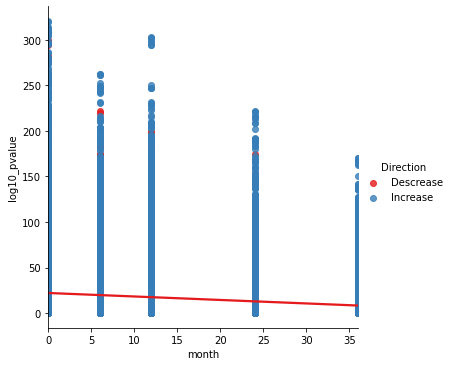

In [21]:
sns.lmplot(x='month', y='log10_pvalue', hue='Direction', 
           data=disc_replicated_df, palette='Set1')

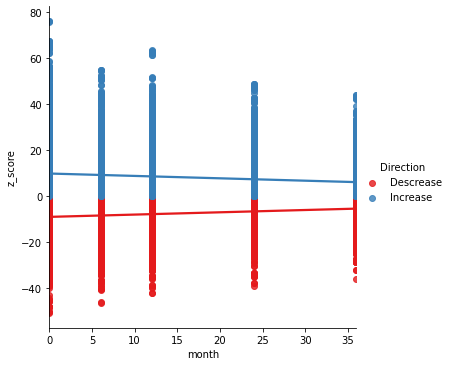

In [22]:
sns.lmplot(x='month', y='z_score', hue='Direction', 
           data=disc_replicated_df, palette='Set1')

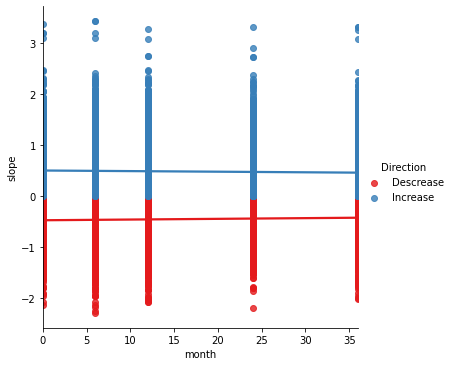

In [23]:
sns.lmplot(x='month', y='slope', hue='Direction', 
           data=disc_replicated_df, palette='Set1')

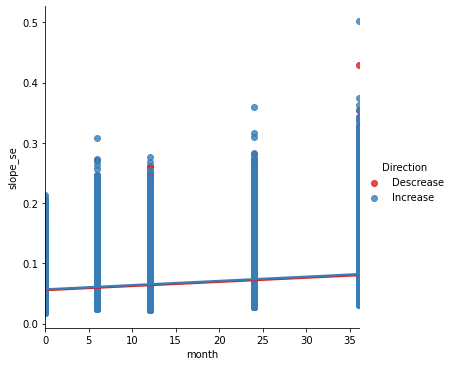

In [24]:
sns.lmplot(x='month', y='slope_se', hue='Direction', 
           data=disc_replicated_df, palette='Set1')

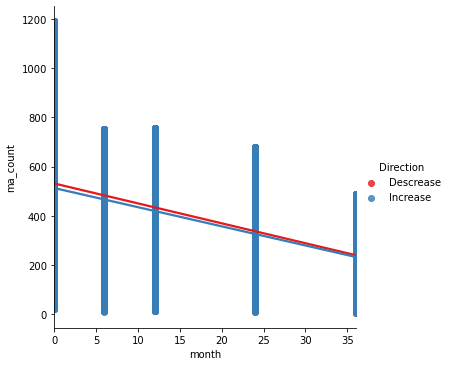

In [25]:
sns.lmplot(x='month', y='ma_count', hue='Direction', 
           data=disc_replicated_df, palette='Set1')

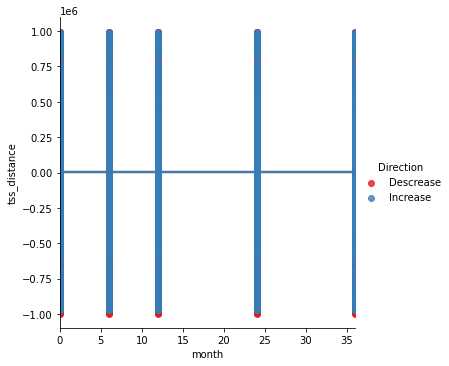

In [26]:
sns.lmplot(x='month', y='tss_distance', hue='Direction', 
           data=disc_replicated_df, palette='Set1')

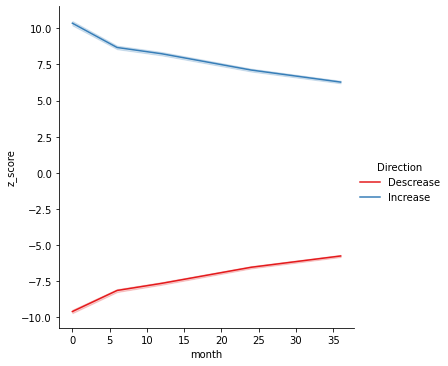

In [27]:
sns.relplot(x='month', y='z_score', kind='line', hue='Direction',
            data=disc_replicated_df, palette='Set1')

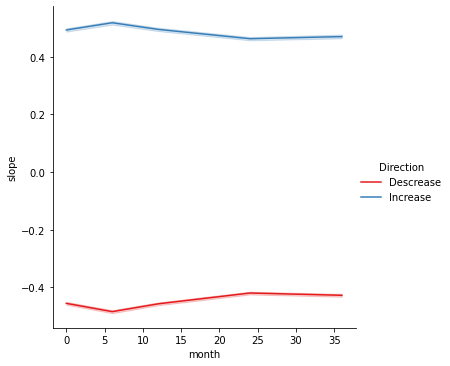

In [28]:
sns.relplot(x='month', y='slope', kind='line', hue='Direction',
            data=disc_replicated_df, palette='Set1')

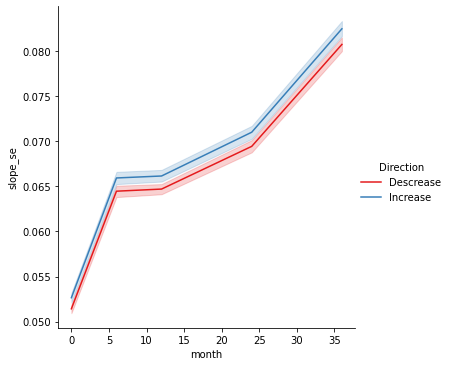

In [29]:
sns.relplot(x='month', y='slope_se', kind='line', hue='Direction',
            data=disc_replicated_df, palette='Set1')

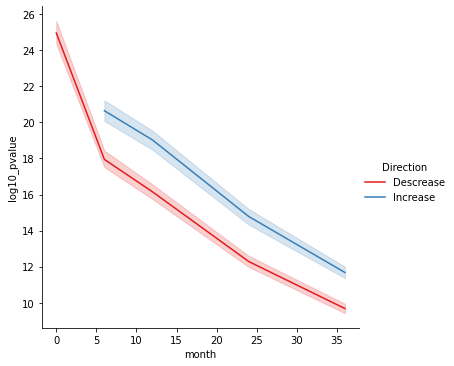

In [30]:
sns.relplot(x='month', y='log10_pvalue', kind='line', hue='Direction',
            data=disc_replicated_df, palette='Set1')

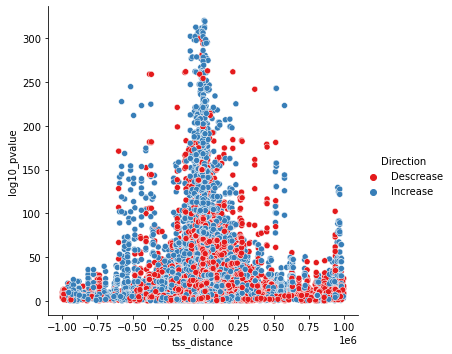

In [31]:
sns.relplot(x='tss_distance', y='log10_pvalue',hue='Direction',
            data=disc_replicated_df, palette='Set1')

<AxesSubplot:xlabel='tss_distance', ylabel='log10_pvalue'>

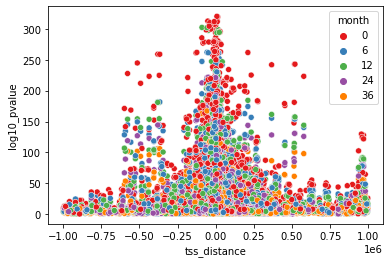

In [32]:
sns.scatterplot(x='tss_distance', y='log10_pvalue', hue='month',
                data=disc_replicated_df.sample(frac=1), palette='Set1')

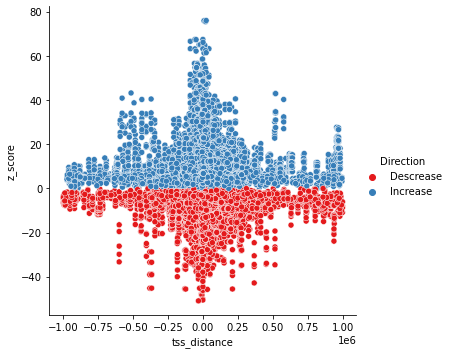

In [33]:
sns.relplot(x='tss_distance', y='z_score',hue='Direction',
            data=disc_replicated_df, palette='Set1')

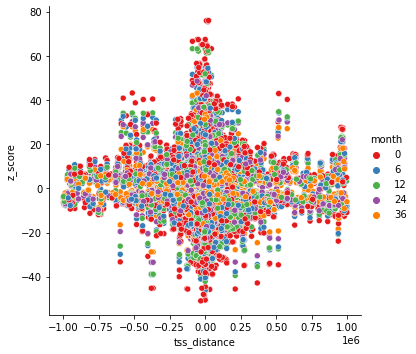

In [34]:
sns.relplot(x='tss_distance', y='z_score',hue='month',
            data=disc_replicated_df.sample(frac=1), palette='Set1')

In [35]:
disc_replicated_df.loc[disc_replicated_df['month'] == 0]['Direction'].value_counts()

Increase     9495
Descrease    9246
Name: Direction, dtype: int64

In [36]:
disc_replicated_df.loc[(disc_replicated_df['month'] == 0) & 
                       (disc_replicated_df['Direction'] == 'Increase')]['log10_pvalue'].value_counts()

inf           25
88.226370      3
89.278927      2
11.278651      2
124.967922     2
              ..
9.935266       1
40.059748      1
7.961405       1
6.454414       1
79.793803      1
Name: log10_pvalue, Length: 9337, dtype: int64